In [1]:
! python3 --version

Python 3.10.12


In [1]:
import sentencepiece
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech
from transformers import SpeechT5HifiGan
from datasets import load_dataset
import torch
import config

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split= "validation")
speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

tokenizer_config.json: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [00:00<00:00, 1.08MB/s]
spm_char.model: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 238k/238k [00:00<00:00, 62.8MB/s]
added_tokens.json: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40.0/40.0 [00:00<00:00, 170kB/s]
special_tokens_map.json: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234/234 [00:00<00:00, 1.04MB/s]
config.json: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.06k/2.06k [00:00<00

The SpeechT5 TTS model uses speaker embeddings that capture a particular speaker's voice characteristics.

Speaker embeddings is a method of representing a speaker's identity in a compact way, as a vector of fixed size, regardless of length of utterance. This embeddings capture essential information about a speaker's voice, accent, intonation, and other unique characteristics that distinguish one speaker from anothe

### Go to [GPU START](#GPUstart)r.

In [19]:
def play_processed_model(text_arr: list[str], model, embeddings):
    from IPython.display import Audio
    audio_samples = []

    for item in text_arr:

        ## Tokenise the input text
        input = processor (text= item, return_tensors = "pt") ## "pt" --> pytorch tensors
        print("Encoded input for the model: ", input) ## returns pytorch tensors

        ## model generates speech using the input passed into it, the speaker embeddings defined in the cell above,
        ## and a vocoder.
        ## If a vocoder is not specified, this method outputs a spectrogram.
        speech = model.generate_speech(input["input_ids"], speaker_embeddings, vocoder = vocoder)
        audio_samples.append(Audio(speech, rate = 16000))

    return audio_samples

audio_samples = play_processed_model([
    "Hello, how are you?",
    "I tell you already, I don't like this",
    "Today so hot leh"
], model=model, embeddings=speaker_embeddings)

for x in audio_samples:
    display(x)

Encoded input for the model:  {'input_ids': tensor([[ 4, 35,  5, 15, 15,  8, 23,  4, 11,  8, 20,  4,  7, 13,  5,  4, 22,  8,
         16, 41,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
Encoded input for the model:  {'input_ids': tensor([[ 4, 30,  4,  6,  5, 15, 15,  4, 22,  8, 16,  4,  7, 15, 13,  5,  7, 14,
         22, 23,  4, 30,  4, 14,  8,  9, 31,  6,  4, 15, 10, 28,  5,  4,  6, 11,
         10, 12,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
Encoded input for the model:  {'input_ids': tensor([[ 4, 32,  8, 14,  7, 22,  4, 12,  8,  4, 11,  8,  6,  4, 15,  5, 11,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


### Finetuning on IMDA Part 1

In [3]:
from datasets import load_dataset

imda_dataset = load_dataset(
    "JET2001/imda-nsc-processed",
    split = 'train',
    token = config.HF_TOKEN
)

Resolving data files:   0%|                                                                                                                                                       | 0/103 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
imda_dataset = load_dataset(
    "JET2001/imda-nsc-processed",
    split = 'train',
    data_files = "data/train-000[0-2][0-9]-of-00103-*.parquet", ## download first 50 or so speakers
    verification_mode = "no_checks",
    token= config.HF_TOKEN
)

Resolving data files: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 141.05it/s]



























In [ ]:
import os 
dataset_path = "hf-imda-nsc-p1-150-speakers"
os.mkdir(dataset_path)
imda_dataset.save_to_disk(dataset_path)

In [6]:
from datasets import load_from_disk
imda_dataset = load_from_disk("hf-imda-nsc-p1")

/usr/local/lib/python3.10/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [3]:
from datasets import load_from_disk
imda_dataset = load_from_disk("hf-imda-nsc-p1-150-speakers")

In [4]:
from datasets import Audio
imda_dataset = imda_dataset.cast_column("audio", Audio(sampling_rate=16000))

In [5]:
print("Number of speakers = ", len(set(imda_dataset['speaker'])))

Number of speakers =  144


### Clean Up the text

In [6]:
tokenizer = processor.tokenizer

In [7]:
def extract_all_chars(batch):
    all_text = " ".join(batch["transcription"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

vocabs = imda_dataset.map(
    extract_all_chars, 
    batched=True, 
    batch_size=-1, 
    keep_in_memory=True, 
    remove_columns=imda_dataset.column_names,
)

imda_dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k,_ in tokenizer.get_vocab().items()}

Map: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97050/97050 [00:00<00:00, 465831.11 examples/s]


Now we have two sets of characters, one with the vocabulary from the dataset and one with the vocabulary from the tokenizer. By taking the difference between these sets, we find the characters that are in the dataset but not in the tokenizer.

In [8]:
imda_dataset_vocab - tokenizer_vocab

{' ', '*', '<', '>', '’'}

In [9]:
replacements = [
    ('*', ''),
    ('<', ''),
    ('>', ''),
    ('’', '')
]
def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["transcription"] = inputs["transcription"].replace(src, dst)
    return inputs

imda_dataset = imda_dataset.map(cleanup_text)

Map: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97050/97050 [01:26<00:00, 1118.94 examples/s]


### Speakers
We have a multi-speaker dataset with 32350 samples. First check the number of speakers

In [10]:
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in imda_dataset['speaker']:
    speaker_counts[speaker_id] += 1

In [11]:
speaker_counts

defaultdict(int,
            {1: 682,
             2: 532,
             3: 693,
             4: 651,
             5: 337,
             6: 784,
             7: 720,
             8: 725,
             9: 687,
             10: 380,
             11: 711,
             12: 786,
             13: 742,
             14: 674,
             16: 289,
             17: 727,
             18: 733,
             19: 632,
             20: 766,
             21: 728,
             22: 606,
             23: 571,
             24: 759,
             25: 698,
             26: 621,
             27: 657,
             28: 754,
             29: 616,
             30: 794,
             31: 740,
             32: 601,
             33: 731,
             34: 745,
             35: 721,
             36: 735,
             37: 641,
             38: 635,
             39: 757,
             40: 698,
             41: 744,
             42: 315,
             43: 792,
             44: 693,
             45: 606,
             46: 767,
  

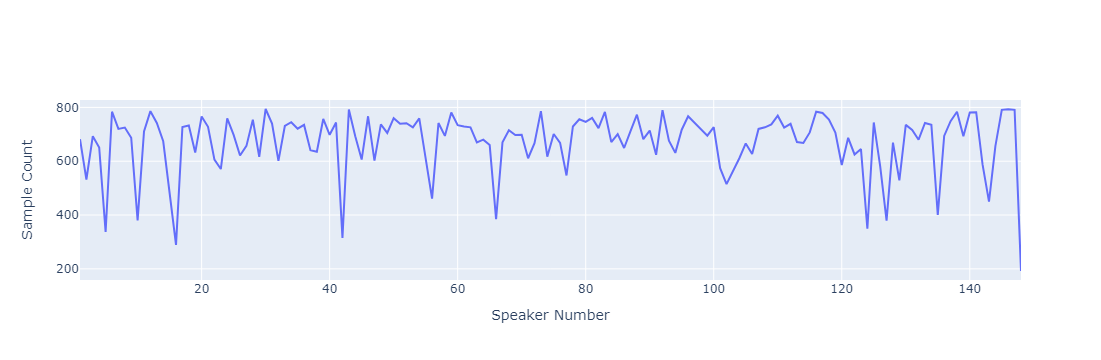

In [13]:

import plotly.graph_objects as go
fig = go.Figure()
speaker_ids = [x for x in speaker_counts.keys()]
speaker_samples = [speaker_counts[x] for x in speaker_ids]
fig.add_trace(
    go.Scatter(x = speaker_ids, y = speaker_samples)
)
fig.update_xaxes(title = "Speaker Number")
fig.update_yaxes(title = "Sample Count")
fig.write_html("speaker_frequency-150-speakers.html")
fig.show()

Make our model slightly more balanced if we remove those with less than 600 samples.

In [14]:
def select_speaker(speaker_id):
    return speaker_counts[speaker_id] >= 600

processed_imda_dataset = imda_dataset.filter(select_speaker, input_columns = ['speaker'])

Filter: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97050/97050 [00:00<00:00, 568343.40 examples/s]


In [15]:
print("Remaining speakers =", len(set(processed_imda_dataset['speaker'])))

Remaining speakers = 124


In [16]:
len(processed_imda_dataset)

88090

In [20]:
import os 
os.mkdir('processed-hf-imda-nsc-p1')
processed_imda_dataset.save_to_disk('processed-hf-imda-nsc-p1')

Saving the dataset (10/10 shards): 100%|█| 29596/29596 [05:51<00:0


In [3]:
from datasets import load_from_disk
processed_imda_dataset = load_from_disk('processed-hf-imda-nsc-p1')

/usr/local/lib/python3.10/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


### Speaker Embeddings
To allow the TTS model to distinguish between multiple speakers, we will need to create a speaker embedding for each example. The speaker embedding is simply an additional input into the model that captures a particular speaker's voice characteristics.

To create speaker embeddings, we can use the spkrec-xvect-voxceleb model from SpeechBrain. The following defines a function `create_speaker_embedding()` that takes an input audio waveform and outputs a 512-element vector containing the corresponding speaker embedding.

In [18]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"
speaker_model = EncoderClassifier.from_hparams(
    source = spk_model_name,
    run_opts = {"device": "cuda"},
    savedir = os.path.join("/tmp", spk_model_name)
)

def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim = 2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

In [15]:
! python3 --version
torch.__version__

Python 3.10.12


'2.1.1+cu121'

### Preparing the dataset
The `prepare_dataset` function takes in a single example and uses a `SpeechT5Processor` object to tokenize the input text and load the target audio into a log mel spectrogram. It also adds the speaker embeddings as an additional input.

In [19]:
def prepare_dataset(example):
    ## load the audio data
    audio = example['audio']

    ## feature extraction and tokenisation
    example = processor(
        text = example['transcription'],
        audio_target = audio['array'],
        sampling_rate = audio['sampling_rate'],
        return_attention_mask = False
    )

    # strip off the batch dimension
    example['labels'] = example['labels'][0]

    # use Speechbrain to obtain x-vector
    example['speaker_embeddings'] = create_speaker_embedding(audio['array'])
    return example

#### Test one example:

In [20]:
processed_example = prepare_dataset(processed_imda_dataset[0])

Note:
- tokens for the input text are in `input_ids`
- speaker embedding in `speaker_embeddings`
- target spectrogram in `labels`

In [21]:
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

The tokens should decode into the original text, with `</s>` to mark the end of the sentence.

In [22]:
tokenizer = processor.tokenizer
print("some examples of tokens = ", processed_example['input_ids'][:21])
print('first 20 tokens decoded = ', tokenizer.decode(processed_example['input_ids'][:21]))
tokenizer.decode(processed_example['input_ids'])

some examples of tokens =  [4, 6, 11, 5, 13, 5, 4, 20, 5, 13, 5, 4, 25, 7, 13, 13, 5, 15, 12, 4, 8]
first 20 tokens decoded =  there were barrels o


'there were barrels of wine in the huge cellar</s>'

In [23]:
processed_example['speaker_embeddings'].shape

(512,)

Labels should be a log-mel spectrogram with 80 mel bins.

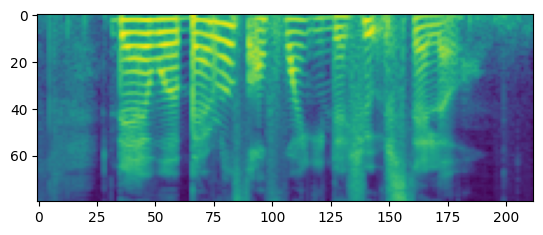

In [31]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(processed_example['labels'].T)
plt.savefig('mel-spectrogram-for-speaker-0.png')

If we run a vocoder on the log mel spectrogram, it should produce the original audio again. We can use the HiFi-GAN vocoder from the original SpeechT5 Model.

In [24]:
print(vocoder)
spectrogram = torch.tensor(processed_example['labels'])
with torch.no_grad(): ## do not update weights
    speech = vocoder(spectrogram)
from IPython.display import Audio
Audio(speech.cpu().numpy(), rate = 16000)

SpeechT5HifiGan(
  (conv_pre): Conv1d(80, 512, kernel_size=(7,), stride=(1,), padding=(3,))
  (upsampler): ModuleList(
    (0): ConvTranspose1d(512, 256, kernel_size=(8,), stride=(4,), padding=(2,))
    (1): ConvTranspose1d(256, 128, kernel_size=(8,), stride=(4,), padding=(2,))
    (2): ConvTranspose1d(128, 64, kernel_size=(8,), stride=(4,), padding=(2,))
    (3): ConvTranspose1d(64, 32, kernel_size=(8,), stride=(4,), padding=(2,))
  )
  (resblocks): ModuleList(
    (0): HifiGanResidualBlock(
      (convs1): ModuleList(
        (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(3,), dilation=(3,))
        (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(5,), dilation=(5,))
      )
      (convs2): ModuleList(
        (0-2): 3 x Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      )
    )
    (1): HifiGanResidualBlock(
      (convs1): ModuleList(
        (0): Conv1d(256, 256,

In [25]:
processed_imda_dataset = processed_imda_dataset.map(
    prepare_dataset, remove_columns=processed_imda_dataset.column_names
)

Map: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88090/88090 [58:32<00:00, 25.08 examples/s]


In [26]:
import os
os.mkdir('hf-imda-dataset-with-embeddings-150-speakers')

In [27]:
processed_imda_dataset.save_to_disk('hf-imda-dataset-with-embeddings-150-speakers')

Saving the dataset (20/20 shards): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88090/88090 [00:15<00:00, 5705.01 examples/s]


In [28]:
processed_imda_dataset.push_to_hub??

Signature:
processed_imda_dataset.push_to_hub(
    repo_id: str,
    config_name: str = 'default',
    split: Optional[str] = None,
    commit_message: Optional[str] = None,
    private: Optional[bool] = False,
    token: Optional[str] = None,
    revision: Optional[str] = None,
    branch='deprecated',
    create_pr: Optional[bool] = False,
    max_shard_size: Union[str, int, NoneType] = None,
    num_shards: Optional[int] = None,
    embed_external_files: bool = True,
)
Source:   
    def push_to_hub(
        self,
        repo_id: str,
        config_name: str = "default",
        split: Optional[str] = None,
        commit_message: Optional[str] = None,
        private: Optional[bool] = False,
        token: Optional[str] = None,
        revision: Optional[str] = None,
        branch="deprecated",
        create_pr: Optional[bool] = False,
        max_shard_size: Optional[Union[int, str]] = None,
        num_shards: Optional[int] = None,
        embed_external_files: bool = True,
 

In [ ]:
processed_imda_dataset.push_to_hub(
    repo_id = "JET2001/hf-imda-dataset-with-embeddings",
    token = config.HF_TOKEN
)

In [ ]:
processed_imda_dataset.push_to_hub(
    repo_id = "JET2001/hf-imda-dataset-with-embeddings-150-speakers",
    token = config.HF_TOKEN,
    private = True
)

Creating parquet from Arrow format: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70ba/s]


### Train / Test split <a id = "GPU-start"></a>

### Run either of these options:
1. Load from disk

In [3]:
from datasets import load_from_disk
processed_imda_dataset = load_from_disk('hf-imda-dataset-with-embeddings-150-speakers')

2. Load from hub and save to disk

In [3]:
processed_imda_dataset = load_dataset(
    "JET2001/hf-imda-dataset-with-embeddings-150",
    token = config.HF_TOKEN
)
processed_imda_dataset = processed_imda_dataset['train']
processed_imda_dataset.save_to_disk('hf-imda-dataset-with-embeddings')







Saving the dataset (7/7 shards): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29596/29596 [00:29<00:00, 1007.26 examples/s]


In [10]:
! processed_imda_dataset.train_test_split??

Signature:
processed_imda_dataset.train_test_split(
    test_size: Union[float, int, NoneType] = None,
    train_size: Union[float, int, NoneType] = None,
    shuffle: bool = True,
    stratify_by_column: Optional[str] = None,
    seed: Optional[int] = None,
    generator: Optional[numpy.random._generator.Generator] = None,
    keep_in_memory: bool = False,
    load_from_cache_file: Optional[bool] = None,
    train_indices_cache_file_name: Optional[str] = None,
    test_indices_cache_file_name: Optional[str] = None,
    writer_batch_size: Optional[int] = 1000,
    train_new_fingerprint: Optional[str] = None,
    test_new_fingerprint: Optional[str] = None,
) -> 'DatasetDict'
Source:   
    @transmit_format
    @fingerprint_transform(
        inplace=False,
        randomized_function=True,
        fingerprint_names=["train_new_fingerprint", "test_new_fingerprint"],
        ignore_kwargs=["load_from_cache_file", "train_indices_cache_file_name", "test_indices_cache_file_name"],
    )
    

In [4]:
dataset = processed_imda_dataset.train_test_split(test_size = 0.2, seed = 1708)
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 70472
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 17618
    })
})

In [14]:
dataset.push_to_hub??

Signature:
dataset.push_to_hub(
    repo_id,
    config_name: str = 'default',
    commit_message: Optional[str] = None,
    private: Optional[bool] = False,
    token: Optional[str] = None,
    revision: Optional[str] = None,
    branch='deprecated',
    create_pr: Optional[bool] = False,
    max_shard_size: Union[str, int, NoneType] = None,
    num_shards: Optional[Dict[str, int]] = None,
    embed_external_files: bool = True,
)
Source:   
    def push_to_hub(
        self,
        repo_id,
        config_name: str = "default",
        commit_message: Optional[str] = None,
        private: Optional[bool] = False,
        token: Optional[str] = None,
        revision: Optional[str] = None,
        branch="deprecated",
        create_pr: Optional[bool] = False,
        max_shard_size: Optional[Union[int, str]] = None,
        num_shards: Optional[Dict[str, int]] = None,
        embed_external_files: bool = True,
    ):
        """Pushes the [`DatasetDict`] to the hub as a Parquet datas

In [ ]:
dataset.push_to_hub(
    repo_id = "JET2001/hf-imda-dataset-with-embeddings-p1-150-speakers",
    private = True,
    token = config.HF_TOKEN
)

### Collators to make batches
We need to define a custom collator to combine multiple examples into a batch. This will pad shorter sequences with padding tokens. For spectrogram labels, the padded tokens are replaced with the special value -100. This special value tells the model to ignore that part of the spectrogram when calculating spectrogram loss.

In [6]:
from transformers import SpeechT5Config
! SpeechT5Config??

Init signature:
SpeechT5Config(
    vocab_size=81,
    hidden_size=768,
    encoder_layers=12,
    encoder_attention_heads=12,
    encoder_ffn_dim=3072,
    encoder_layerdrop=0.1,
    decoder_layers=6,
    decoder_ffn_dim=3072,
    decoder_attention_heads=12,
    decoder_layerdrop=0.1,
    hidden_act='gelu',
    positional_dropout=0.1,
    hidden_dropout=0.1,
    attention_dropout=0.1,
    activation_dropout=0.1,
    initializer_range=0.02,
    layer_norm_eps=1e-05,
    scale_embedding=False,
    feat_extract_norm='group',
    feat_proj_dropout=0.0,
    feat_extract_activation='gelu',
    conv_dim=(512, 512, 512, 512, 512, 512, 512),
    conv_stride=(5, 2, 2, 2, 2, 2, 2),
    conv_kernel=(10, 3, 3, 3, 3, 2, 2),
    conv_bias=False,
    num_conv_pos_embeddings=128,
    num_conv_pos_embedding_groups=16,
    apply_spec_augment=True,
    mask_time_prob=0.05,
    mask_time_length=10,
    mask_time_min_masks=2,
    mask_feature_prob=0.0,
    mask_feature_length=10,
    mask_feature_min_masks

In [5]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union
from transformers import SpeechT5Config

## this class is a data collator class named 'TTSDataCollatorWithPadding' for TTS tasks using the transformers library. 

## The @dataclass annotation automatically generates special methods such as __init__ and __repr__
@dataclass
class TTSDataCollatorWithPadding:
    processor: Any
    # configuration = SpeechT5Config()
    ## This method allows an instance of a class to be callable, it takes in a list of features as input, where
    ## each feature is a dictionary with keys like "input_ids", "labels", "speaker_embeddings"
    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        ## Separate the input features into lists of input_ids, labels and embeddings
        input_ids = [{"input_ids":feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature['labels']} for feature in features]
        speaker_features = [feature['speaker_embeddings'] for feature in features]

        # collate the inputs and targets and create a batch with pytorch tensors (pt)
        batch = processor.pad(
            input_ids = input_ids,
            labels = label_features,
            return_tensors = "pt"
        )
        # replace padding with loss correctly
        batch['labels'] = batch['labels'].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )
        # Not used during fine-tuning
        del batch['decoder_attention_mask']
        # round down target lengths to multiple of reduction factor
        if SpeechT5Config().reduction_factor > 1:
            target_lengths = torch.tensor([
                len(feature["input_values"]) for feature in label_features
            ])
            target_lengths = target_lengths.new([
                (length - length % SpeechT5Config().reduction_factor) for length in target_lengths
            ])
            max_length = max(target_lengths)
            batch['labels'] = batch['labels'][:, :max_length]

        # add in the speaker embeddings into the batch
        batch['speaker_embeddings'] = torch.tensor(speaker_features)

        return batch

In SpeechT5, the input to the decoder part of the model is reduced by a factor 2. In other words, it throws away every other timestep from the target sequence. The decoder then predicts a sequence that is twice as long. Since the original target sequence length may be odd, the data collator makes sure to round the maximum length of the batch down to be a multiple of 2.

In [6]:
data_collator = TTSDataCollatorWithPadding(processor = processor)

#### Test the data collator

In [7]:
features = [
    dataset['train'][0],
    dataset['train'][1],
    dataset['train'][20]
]
batch = data_collator(features)
{k:v.shape for k, v in batch.items()}

{'input_ids': torch.Size([3, 106]),
 'attention_mask': torch.Size([3, 106]),
 'labels': torch.Size([3, 410, 80]),
 'speaker_embeddings': torch.Size([3, 512])}

### Upload model checkpoints directly to Huggingface Hub

In [10]:
from transformers import Seq2SeqTrainingArguments
! Seq2SeqTrainingArguments??

Init signature:
Seq2SeqTrainingArguments(
    output_dir: str,
    overwrite_output_dir: bool = False,
    do_train: bool = False,
    do_eval: bool = False,
    do_predict: bool = False,
    evaluation_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no',
    prediction_loss_only: bool = False,
    per_device_train_batch_size: int = 8,
    per_device_eval_batch_size: int = 8,
    per_gpu_train_batch_size: Optional[int] = None,
    per_gpu_eval_batch_size: Optional[int] = None,
    gradient_accumulation_steps: int = 1,
    eval_accumulation_steps: Optional[int] = None,
    eval_delay: Optional[float] = 0,
    learning_rate: float = 5e-05,
    weight_decay: float = 0.0,
    adam_beta1: float = 0.9,
    adam_beta2: float = 0.999,
    adam_epsilon: float = 1e-08,
    max_grad_norm: float = 1.0,
    num_train_epochs: float = 3.0,
    max_steps: int = -1,
    lr_scheduler_type: Union[transformers.trainer_utils.SchedulerType, str] = 'linear',
    warmup_ratio: float = 0.0

In [37]:
! nvidia-smi

Fri Dec  8 10:46:38 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           On  | 00000000:00:1E.0 Off |                    0 |
| N/A   34C    P0              38W / 300W |    612MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
from transformers import Seq2SeqTrainingArguments
training_args = Seq2SeqTrainingArguments(
    output_dir = 'speecht5_tts_imda_nsc_p1',
    per_device_train_batch_size= 32,
    per_device_eval_batch_size= 64, #sets the batch size for evaluation on each device
    gradient_accumulation_steps=2,
    learning_rate=1e-5, 
    warmup_steps=500, # number of steps for warmup where the learning rate gradually increases
    num_train_epochs = 10.0,
    gradient_checkpointing=True, # enables a memory saving technique during training
    fp16=True, # mixed precision training - floating point 16 = True (accelerates training)
    evaluation_strategy='steps', # evaluation is performed at regular step intervals defined by 'eval-steps'
    save_strategy= 'steps',
    save_steps= 1000, # determines how often to save model during training
    eval_steps= 1000, # specifies evaluation step interval
    logging_steps=25, # sets the interval for logging training information
    report_to=['tensorboard'], # indicates where to save training results
    load_best_model_at_end=True, 
    greater_is_better=False, # specifies whether a higher value for evaluation metric is considered better
    label_names=['labels'], # Names of labels in dataset
    push_to_hub=True, # push to huggingface
    hub_private_repo=True, 
    hub_token=config.HF_TOKEN
)

Create the trainer object using the model, dataset and data collector

In [44]:
from transformers import Seq2SeqTrainer
! Seq2SeqTrainer??

Init signature:
Seq2SeqTrainer(
    model: Union[ForwardRef('PreTrainedModel'), torch.nn.modules.module.Module] = None,
    args: 'TrainingArguments' = None,
    data_collator: Optional[ForwardRef('DataCollator')] = None,
    train_dataset: Optional[torch.utils.data.dataset.Dataset] = None,
    eval_dataset: Union[torch.utils.data.dataset.Dataset, Dict[str, torch.utils.data.dataset.Dataset], NoneType] = None,
    tokenizer: Optional[ForwardRef('PreTrainedTokenizerBase')] = None,
    model_init: Optional[Callable[[], ForwardRef('PreTrainedModel')]] = None,
    compute_metrics: Optional[Callable[[ForwardRef('EvalPrediction')], Dict]] = None,
    callbacks: Optional[List[ForwardRef('TrainerCallback')]] = None,
    optimizers: Tuple[torch.optim.optimizer.Optimizer, torch.optim.lr_scheduler.LambdaLR] = (None, None),
    preprocess_logits_for_metrics: Optional[Callable[[torch.Tensor, torch.Tensor], torch.Tensor]] = None,
)
Docstring:     
Trainer is a simple but feature-complete training and

In [9]:
## Add an early stopping callback
from transformers import EarlyStoppingCallback
earlyStop = EarlyStoppingCallback(early_stopping_patience = 3) ## stop training after 3 evaluations without improvement.

In [10]:
from transformers import Seq2SeqTrainer
trainer = Seq2SeqTrainer(
    args = training_args,
    model = model,
    train_dataset=dataset['train'],
    eval_dataset= dataset['test'],
    data_collator= data_collator,
    tokenizer= processor.tokenizer,
    callbacks= [earlyStop]
)

Training will take several hours depending on your GPU.

In [11]:
import torch
torch.cuda.empty_cache()

In [12]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=11010, training_loss=0.4504523334884297, metrics={'train_runtime': 21497.362, 'train_samples_per_second': 32.782, 'train_steps_per_second': 0.512, 'total_flos': 7.7973754712851e+16, 'train_loss': 0.4504523334884297, 'epoch': 10.0})

#### Training Screenshot of Output (50 speakers)
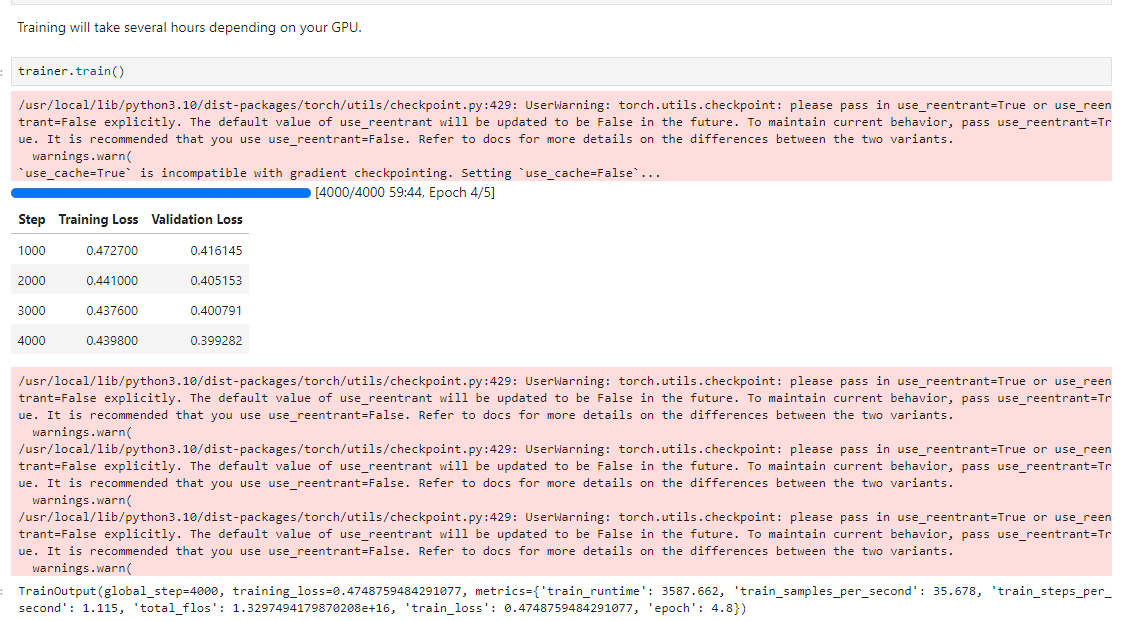

#### Training Screenshot of Output (150 speakers)
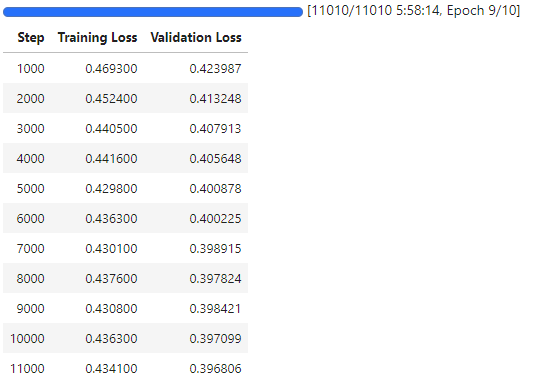

### Push model to hub

In [13]:
### Push a model card to the hub
kwargs = {
    "dataset_tags": "speecht5_imda_nsc_p1",
    "dataset": "IMDA National Speech Corpus",
    "dataset_args": "config: p1-v2, split: train",
    "language": "en",
    "model_name": "Speech T5 TTS English",
    "finetuned_from": "microsoft/speecht5_tts",
    "tasks": "text-to-speech",
    "tags": "."
}
trainer.push_to_hub(**kwargs)

events.out.tfevents.1702053642.ce889efe64a5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78.2k/78.2k [00:00<00:00, 461kB/s]


'https://huggingface.co/JET2001/speecht5_tts_imda_nsc_p1/tree/main/'

## Evaluation of FineTuned Model

In [5]:
SpeechT5ForTextToSpeech.from_pretrained??

Signature:
SpeechT5ForTextToSpeech.from_pretrained(
    pretrained_model_name_or_path: Union[str, os.PathLike, NoneType],
    *model_args,
    config: Union[transformers.configuration_utils.PretrainedConfig, str, os.PathLike, NoneType] = None,
    cache_dir: Union[str, os.PathLike, NoneType] = None,
    ignore_mismatched_sizes: bool = False,
    force_download: bool = False,
    local_files_only: bool = False,
    token: Union[str, bool, NoneType] = None,
    revision: str = 'main',
    use_safetensors: bool = None,
    **kwargs,
)
Source:   
    @classmethod
    def from_pretrained(
        cls,
        pretrained_model_name_or_path: Optional[Union[str, os.PathLike]],
        *model_args,
        config: Optional[Union[PretrainedConfig, str, os.PathLike]] = None,
        cache_dir: Optional[Union[str, os.PathLike]] = None,
        ignore_mismatched_sizes: bool = False,
        force_download: bool = False,
        local_files_only: bool = False,
        token: Optional[Union[str, bool

In [5]:
my_model = SpeechT5ForTextToSpeech.from_pretrained("JET2001/speecht5_tts_imda_nsc_p1", token = config.HF_TOKEN)
my_model

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


SpeechT5ForTextToSpeech(
  (speecht5): SpeechT5Model(
    (encoder): SpeechT5EncoderWithTextPrenet(
      (prenet): SpeechT5TextEncoderPrenet(
        (embed_tokens): Embedding(81, 768, padding_idx=1)
        (encode_positions): SpeechT5ScaledPositionalEncoding(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (wrapped_encoder): SpeechT5Encoder(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (layers): ModuleList(
          (0-11): 12 x SpeechT5EncoderLayer(
            (attention): SpeechT5Attention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (dropout): Dropout(p=0.1, inplace=False)
     

In [26]:
## Get a speaker from the test set
example = dataset['test'][5]
sg_speaker1_embeddings = torch.tensor(example['speaker_embeddings']).unsqueeze(0)
speaker_embeddings.shape

torch.Size([1, 512])

In [28]:
texts = ["Hello, how are you?",
    "I tell you already, I don't like this",
    "Today so hot leh",
    "Walau"]
output = play_processed_model(texts, my_model, sg_speaker1_embeddings)
for x in output:
    display(x)

Encoded input for the model:  {'input_ids': tensor([[ 4, 35,  5, 15, 15,  8, 23,  4, 11,  8, 20,  4,  7, 13,  5,  4, 22,  8,
         16, 41,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
Encoded input for the model:  {'input_ids': tensor([[ 4, 30,  4,  6,  5, 15, 15,  4, 22,  8, 16,  4,  7, 15, 13,  5,  7, 14,
         22, 23,  4, 30,  4, 14,  8,  9, 31,  6,  4, 15, 10, 28,  5,  4,  6, 11,
         10, 12,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
Encoded input for the model:  {'input_ids': tensor([[ 4, 32,  8, 14,  7, 22,  4, 12,  8,  4, 11,  8,  6,  4, 15,  5, 11,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
Encoded input for the model:  {'input_ids': tensor([[ 4, 38,  7, 15,  7, 16,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


In [41]:
texts = ["We usually start with a kopi or teh from the kopitiam before heading off to work or school.", 
         "Traffic can be a bit sian, especially during rush hour.",
         "Work or classes keep us busy until lunch, where we might grab some hawker food like chicken rice or laksa.",
         "Singaporeans love to makan, so dinner can be quite a spread.",
         "Weekends ah? That's when we really let loose.",
         "Maybe head to the heartland mall for some shopping or catch a movie.",
         "Sometimes we just lepak at a friend's place or explore the nightlife.",
         "but not every day is the same tho"]
output = play_processed_model(texts, my_model, sg_speaker1_embeddings)
for x,text in zip(output, texts):
    print(text)
    display(x)

Encoded input for the model:  {'input_ids': tensor([[ 4, 38,  5,  4, 16, 12, 16,  7, 15, 15, 22,  4, 12,  6,  7, 13,  6,  4,
         20, 10,  6, 11,  4,  7,  4, 28,  8, 24, 10,  4,  8, 13,  4,  6,  5, 11,
          4, 19, 13,  8, 18,  4,  6, 11,  5,  4, 28,  8, 24, 10,  6, 10,  7, 18,
          4, 25,  5, 19,  8, 13,  5,  4, 11,  5,  7, 14, 10,  9, 21,  4,  8, 19,
         19,  4,  6,  8,  4, 20,  8, 13, 28,  4,  8, 13,  4, 12, 17, 11,  8,  8,
         15, 26,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
Encoded input for the model:  {'input_ids': tensor([[ 4, 32, 13,  7, 19, 19, 10, 17,  4, 17,  7,  9,  4, 25,  5,  4,  7,  4,
         25, 10,  6,  4, 12, 10,  7,  9, 23,  4,  5, 12, 24,  5, 1

Traffic can be a bit sian, especially during rush hour.


Work or classes keep us busy until lunch, where we might grab some hawker food like chicken rice or laksa.


Singaporeans love to makan, so dinner can be quite a spread.


Weekends ah? That's when we really let loose.


Maybe head to the heartland mall for some shopping or catch a movie.


Sometimes we just lepak at a friend's place or explore the nightlife.


but not every day is the same tho
